# 1. VGG网络

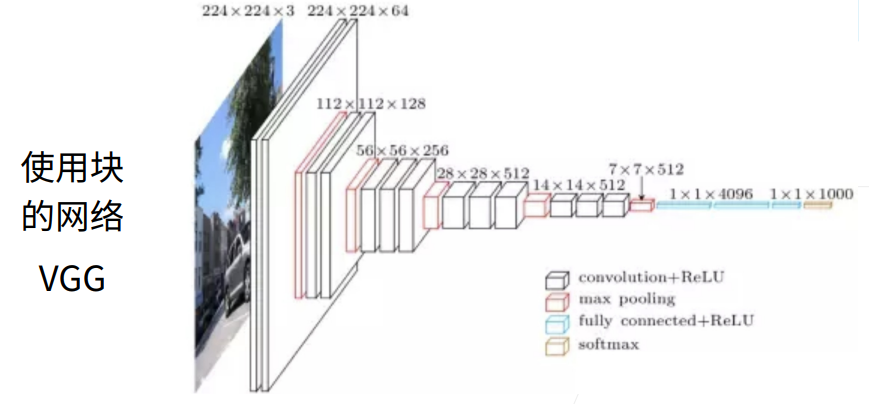

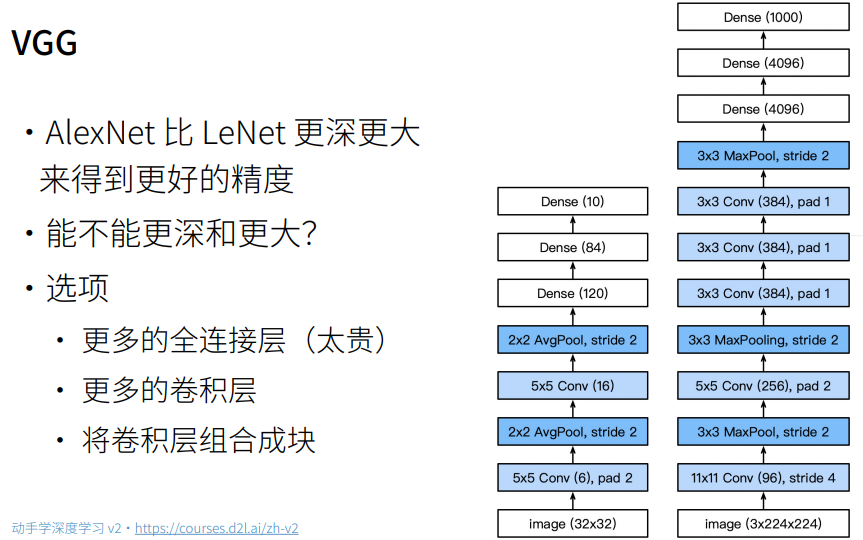

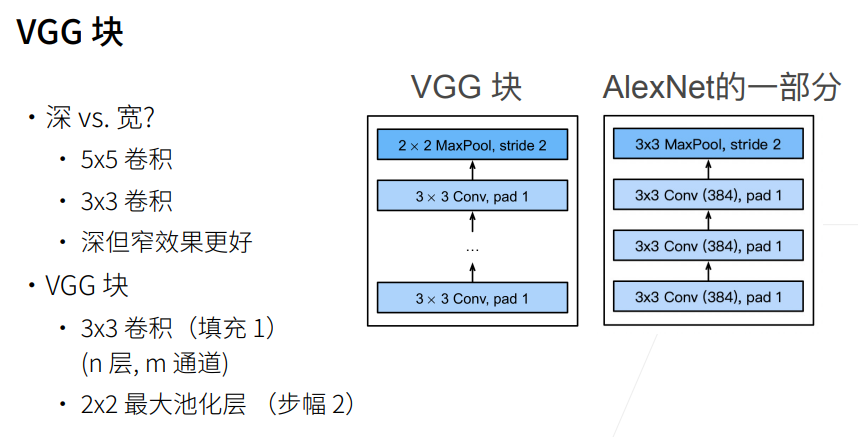

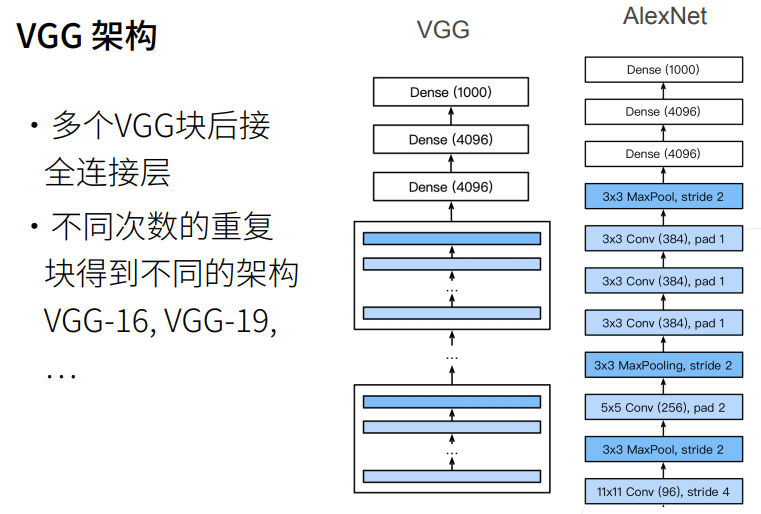

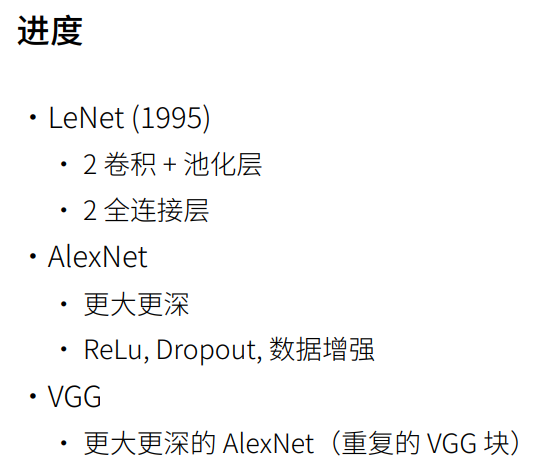

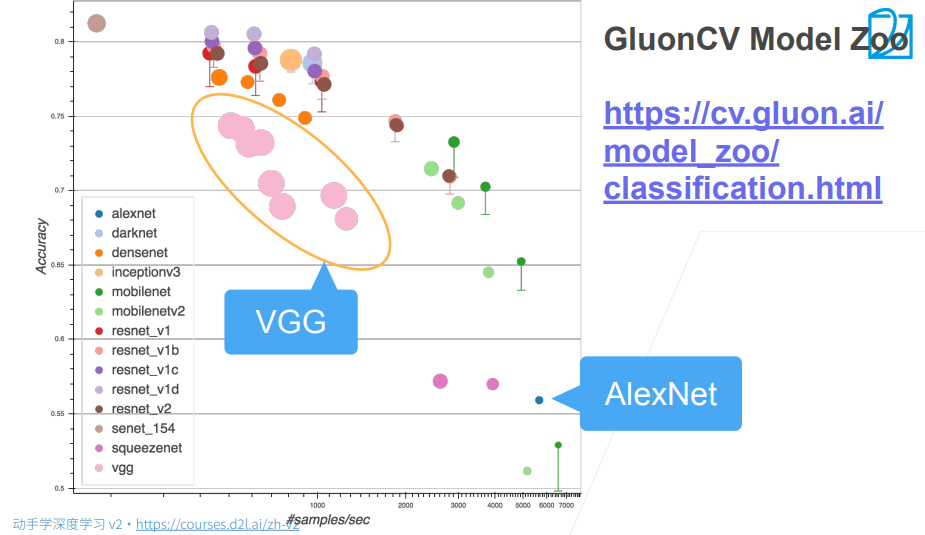

# 2. 总结

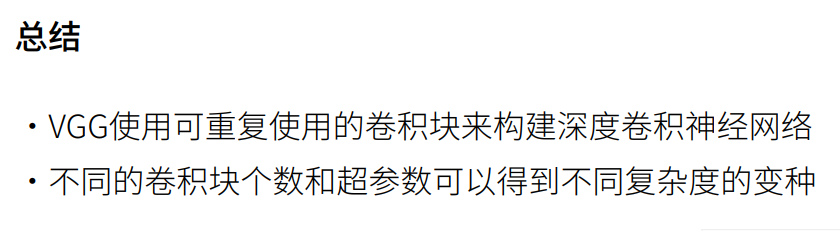

# 1. VGG网络（使用自定义）

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs,in_channels,out_channels): # 卷积层个数、输入通道数、输出通道数
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))      
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers) # *layers表示把列表里面的元素按顺序作为参数输入函数     

conv_arch = ((1,64),(1,128),(2,256),(2,512),(2,512)) # 第一个参数为几层卷积，第二个参数为输出通道数

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
        in_channels = out_channels

    return nn.Sequential(*conv_blks, nn.Flatten(),
                         nn.Linear(out_channels * 7 * 7, 4096),nn.ReLU(),
                         nn.Dropout(0.5), nn.Linear(4096,4096),nn.ReLU(),
                         nn.Dropout(0.5), nn.Linear(4096,10))

net = vgg(conv_arch)

# 观察每个层输出的形状
X = torch.randn(size=(1,1,224,224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape) # VGG使得高宽减半，通道数加倍

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.179, train acc 0.934, test acc 0.915
593.8 examples/sec on cuda:0


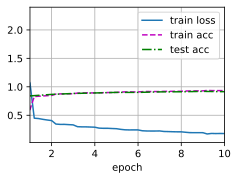

In [2]:
# 由于VGG-11比AlexNet计算量更大，因此构建了一个通道数较少的网络
ratio = 4
small_conv_arch = [(pair[0], pair[1]//ratio) for pair in conv_arch] # 所有输出通道除以4
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,resize=224)    
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())